In [85]:
#standard imports 
import pandas as pd 
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import quandl
import functools
import os
import math
from datetime import datetime, timedelta
import requests
from itertools import combinations
import statsmodels 
import statsmodels.api as sm
from sklearn import metrics
from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn.datasets import make_regression
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import time

from datetime import datetime, timedelta


quandl.ApiConfig.api_key = HIDDEN 
pd.set_option("max_columns", None) 
pd.set_option("max_rows", None)



# Predictive Regression 
## By Zachary Mariani
### Due May 27th, 2021 

### Step 1: Gathering Data

The first thing we want to do is compute weekly Wednesday to Wednesday returns $r^{Equity}$ on the adjusted equity close prices, and similar returns $r^{CDS}$ on the CDS spreads. 

In [26]:
#fixed start and end dates based on the start and end of the CDS data!
start_date = '2018-01-01'
end_date = '2021-04-30'

#generate Wednesdays 
start, end = datetime(2018, 1, 1), datetime(2021, 4, 30)
days = (start + timedelta(days=i) for i in range((end - start).days + 1))
wednesdays = [d for d in days if d.weekday() in [2] ]
wednesdays_strs = [day.strftime("%Y-%m-%d") for day in wednesdays]
wed_sr = np.array(wednesdays)

In [314]:
#import all of the CDS data 
CDS_data = pd.read_table('/Users/zachmariani/Downloads/Liq5YCDS.delim')
#make the index the date
CDS_data.set_index('date', inplace=True)
#drop all of the data on days which aren't Wednesdays 
CDS_data = CDS_data.loc[CDS_data.index.isin(wednesdays_strs)]
#ffill any Wednesdays which are missing data
wed_df = pd.DataFrame(index=wednesdays_strs)
CDS_data = wed_df.merge(CDS_data, left_index=True, right_index = True, how = 'outer').fillna(method = 'ffill')

In [32]:
#now we have to load the corresponding adjusted close prices from Quandl 
wed_df = pd.DataFrame(index = wednesdays)
equity_data = {}
for equity in CDS_data['ticker'].unique():
    temp = quandl.get('EOD/' + equity, start_date = start_date, end_date = end_date, \
                                      column_index = '11')
    #get only Wednesdays 
    temp = temp.loc[temp.index.isin(wednesdays_strs)]
    #fill Wenesdays which are missing some data 
    temp = wed_df.merge(temp, left_index=True, right_index = True, how = 'outer')\
                                                            .fillna(method = 'ffill')
    equity_data[equity] = temp 

Compute weekly Wednesday to Wednesday returns $r^{Equity}$ on the adjusted equity close prices, 

In [34]:
for ticker, data in equity_data.items(): 
    data['Returns'] = data['Adj_Close'].pct_change(1)

and similar “returns” $r^{CDS}$ on the CDS spreads. 

In [ ]:
CDS = {}
for ticker in CDS_data['ticker'].unique():
    temp = CDS_data.loc[(CDS_data['ticker'] == ticker)]
    temp['returns'] = temp['spread5y'].pct_change(1)
    CDS[ticker] = temp

In addition, obtain “market equity returns“ $m$ as the weekly returns on adjusted prices of the SPY ETF.

In [35]:
wed_df = pd.DataFrame(index = wednesdays)
m = quandl.get('EOD/SPY', start_date = start_date, end_date = end_date, \
                                      column_index = '11')
#filter by only wednesdays
m = m.loc[m.index.isin(wednesdays_strs)]
#fill Wenesdays which are missing some data 
m = wed_df.merge(m, left_index=True, right_index = True, how = 'outer')\
                                                            .fillna(method = 'ffill')
m['Returns'] = m['Adj_Close'].pct_change(1)

Now that we are done gathering all of our data to use (including equity returns, CDS returns, and m), we will now begin the second step. 

### Step 2: Models 

Begin by forming a CDS “index return” $r^{Index}$ as the arithmetic average of the $r^{CDS}$

In [36]:
rindex = 0
n = 0
for ticker, data in CDS.items(): 
    rindex += data['returns']
    n += 1

rindex = rindex / n

For each ticker $E$, you will be working with both contemporaneous and predictive models for its "spread returns". The contemporaneous model is of the form: 

$$r_E^{CDS} \sim r_E^{Equity} + r^{Index} + \epsilon$$

Starting from the $K+1$ week of available returns, define weekly calibration data for contemporaneous returns as the returns from the K previous weeks, where in our case, we use $K = 16$. 

Create on contemporaneous model of the (CAPM) form: 

$$r_E^{Equity} \sim m + \epsilon$$ 

using 16 wk boxcar OLS and denote its weekly regression coefficients for the $n$-th row as $\gamma_{E,n}$. 

In [ ]:
#create places to store variables 
eq_lst = []
starting_n_lst = []
n_lst = []
gamma_alpha_lst = []
gamma_lst = []
beta_equity_lst = []
beta_index_lst = []
alpha_second_lst = []
f_En_lst = []
rho_En_lst = []
C_En_lst = []

#for each of the equities that we have data on loop through 
for eq, eq_data in equity_data.items():
    time_0 = time.time()
    print('Begun work on ', eq)

    #generate the OLS boxcar
    #since we're given 17, we just hold it constant 
    for n in range (17, len(m) - 1):
        starting_n = n - 16
        
        #FIRST STAGE
        df_for_model = pd.DataFrame()
        df_for_model['Equity_Returns'] = eq_data['Returns'][starting_n : n]
        df_for_model['m'] = m['Returns'][starting_n : n]
        OLSmodel = statsmodels.formula.api.ols('Equity_Returns ~ m', data = df_for_model).fit()
        gamma_alpha = OLSmodel.params['Intercept']
        gamma = OLSmodel.params['m']
        
        #generate the predicted r^{Equity}_E for second stage 
        fitted_eq = df_for_model['m'] * gamma + gamma_alpha 
        
        #SECOND STAGE 
        df_for_second_model = pd.DataFrame()
        df_for_second_model['r_CDS'] = CDS[eq]['returns'][starting_n : n]
        df_for_second_model['r_Equity'] = fitted_eq.values
        df_for_second_model['r_Index'] = rindex[starting_n : n]
        
        OLSmodel2 = statsmodels.formula.api.ols('r_CDS ~ r_Equity + r_Index', data = df_for_second_model).fit()
        
        beta_equity = OLSmodel2.params['r_Equity']
        beta_index = OLSmodel2.params['r_Index']
        alpha = OLSmodel2.params['Intercept']
        
        #for the upcoming n-th data row, attempt to predict its change in CDS spread 
        # hedged by the contemporaneous predictors. Define the hedge portfolio return 
        # as the returns on predictros in the contemporaneous model 
        
        f_E = beta_equity * df_for_second_model['r_Equity'] + \
               beta_index * df_for_second_model['r_Index'] + alpha 
        
        # Now, we find the residual return as the residual error in this prediction 
        
        rho_E = df_for_second_model['r_CDS'] - f_E
    
        #We also define residual equity return as: 
        # I intrepreted this to be the difference between the actual r_Equity and our predicted values
        C_E = df_for_model['Equity_Returns'].values - df_for_second_model['r_Equity'].values
   
        #save everything 
        eq_lst.append(eq)
        starting_n_lst.append(starting_n)
        n_lst.append(n)
        gamma_alpha_lst.append(gamma_alpha)
        gamma_lst.append(gamma)
        beta_equity_lst.append(beta_equity)
        beta_index_lst.append(beta_index)
        alpha_second_lst.append(alpha)
        f_En_lst.append(f_E[-1])
        rho_En_lst.append(rho_E[-1])
        C_En_lst.append(C_E[-1])
        
    print("Successfully finished, ", eq, 'in :', time.time() - time_0, '\n')

In [106]:
#we just quickly save a full version of the DataFrame and a smaller version which contains 
#more relevant information 
full_contemp_df = pd.DataFrame({
    'Ticker': eq_lst,
    'Starting Ns' : starting_n_lst,
    'N': n_lst,
    'Gamma Alpha' : gamma_alpha_lst,
    'Gamma' : gamma_lst,
    'Beta Eq' : beta_equity_lst,
    'Beta Index' : beta_index_lst,
    'Alpha Second' : alpha_second_lst,
    'F En' : f_En_lst,
    'Rho En' : rho_En_lst,
    'C En' : C_En_lst
})
#relevant information for next round
contemp_df = pd.DataFrame({
    'Ticker': eq_lst,
    'n' : n_lst, 
    'C_En' : C_En_lst, 
    'rho_E' : rho_En_lst
})
#take a look 
contemp_df.head()

,Ticker,n,C_En,rho_E
0,BA,17,0.015565,-0.009579
1,BA,18,-0.056751,0.023052
2,BA,19,0.046785,0.015720
3,BA,20,-0.016563,-0.025941
4,BA,21,0.046974,0.003174


Now that we have generated our *contemp_df* which contains $C_{E, n}, \rho_{E,n}$ for each ticker $E$ and week $n$. We will continue onwards. We will form predictive regression models in exponentially decaying and boxcar forms. We will create new models of the form: 

$$\rho_{E,n} = C_{E,n-1} + \epsilon$$ 

which use the past week's equity return residual to predict new week's changes to CDS spread and call the regression coefficients in this case $\mu_{E,n}$. The residuals of the predictive model itself are: 

$$q_{E,n} = \rho_{E,n} - \mu_{E,n} \cdot C_{E,n-1}$$

In [167]:
#create variables to store 
ticker_lst = []
r_type_lst = []
n_lst = []
mu_lst = []
q_lst = []

#first, we'll do the Boxcar
for eq in contemp_df['Ticker'].unique():
        #get the contemp data specific to each individual ticker 
        eq_data = contemp_df.loc[(contemp_df['Ticker'] == eq)]
        #shift the C_E back forward one 
        eq_data['C_En_minus1'] = eq_data['C_En'].shift(1)
        eq_data.set_index('n', inplace = True)
        
        #for each day
        for n_0 in (eq_data.index): 
            n = n_0 + 17
            
            #build the second stage regression
            df_for_regression = pd.DataFrame()
            df_for_regression['C_En_minus1'] = eq_data['C_En_minus1'].loc[n_0 : n]
            df_for_regression['rho_En'] = eq_data['rho_E'].loc[n_0 : n]
            
            boxcar = statsmodels.formula.api.ols('rho_En ~ C_En_minus1', data = df_for_regression).fit()
            mu = boxcar.params['C_En_minus1']
            mu_alpha = boxcar.params['Intercept']
            
            #generate errors 
            predicted_rho = df_for_regression['C_En_minus1'] * mu + mu_alpha 
            actual_rho = df_for_regression['rho_En']
            
            q = actual_rho - predicted_rho 

            #save everything
            ticker_lst.append(eq)
            r_type_lst.append('B')
            n_lst.append(n)
            mu_lst.append(mu)
            q_lst.append(q.iloc[-1])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [ ]:
#and now we do the decaying data

#first we build a halflife weighting generator
#Source: https://stackoverflow.com/questions/43613407/create-a-list-of-exponential-decay-with-a-predetermine-half-life-python/43613495

def gen_weights(half_life, length):
    coef = math.exp(-math.log(2) / half_life)
    return list(map(lambda t: 1 * coef ** t, range (length) ))

#for every equity 
for eq in contemp_df['Ticker'].unique():
        #get the contemp data specific to each individual ticker 
        eq_data = contemp_df.loc[(contemp_df['Ticker'] == eq)]
        #shift the C_E back forward one 
        eq_data['C_En_minus1'] = eq_data['C_En'].shift(1)
        eq_data.set_index('n', inplace = True)
        
        #for every day
        for n in range(18, len(eq_data.index)): 
            
            #build the weighted rregression
            df_for_regression = pd.DataFrame()
            df_for_regression['C_En_minus1'] = eq_data['C_En_minus1'].loc[ : n]
            df_for_regression['rho_En'] = eq_data['rho_E'].loc[: n]
            
            df_for_regression = df_for_regression.dropna(axis = 0)
            
            Y = df_for_regression['rho_En']
        
            X = df_for_regression['C_En_minus1']
            #we're going to add a constant 
            X = statsmodels.tools.tools.add_constant(X)
            
            weights = gen_weights(12, len(X))
            
            weighted = sm.WLS(Y, X, weights = weights, hasconst = True).fit()
            mu = weighted.params['C_En_minus1']
            
            #the constant doesn't work for the very first data point 
            try:
                mu_alpha = weighted.params['const']
            #so in those cases we just set it equal to 0 
            except: 
                print('Error', eq, n)
                mu_alpha = 0
                
            #then get our predicted Rho
            predicted_rho = df_for_regression['C_En_minus1'] * mu + mu_alpha 
            actual_rho = df_for_regression['rho_En']
            
            q = actual_rho - predicted_rho 

            #then save everything
            ticker_lst.append(eq)
            r_type_lst.append('W')
            n_lst.append(n)
            mu_lst.append(mu)
            q_lst.append(q.iloc[-1])

In [178]:
#save all of our predictive data into a dataframe to use later
predictive_data = pd.DataFrame({
    'Ticker' : ticker_lst,
    'R Type' : r_type_lst, 
    'N' : n_lst, 
    'Mu' : mu_lst, 
    'Q' : q_lst
    
})
predictive_data.head()

,Ticker,R Type,N,Mu,Q
0,BA,B,34,-0.387661,0.013097
1,BA,B,35,-0.298768,0.037753
2,BA,B,36,-0.301827,-0.021216
3,BA,B,37,-0.299606,0.006602
4,BA,B,38,-0.083655,0.057761


### Step 3: Analysis

Compare performance of predictive regressions in exponentially decaying versus boxcar forms. 

In [171]:
#first seperate the data into Boxcar and Weighted 
b_predict = predictive_data.loc[(predictive_data['R Type'] == 'B')] 
w_predict = predictive_data.loc[(predictive_data['R Type'] == 'W')] 

Let's first just graph the performance over time of the two

In [186]:
#get the averages of all of the boxcar and weighted Q errors
#over all of the different tickers
n = 0
boxcar_Q_avg = 0
weighted_Q_avg = 0
for ticker in predictive_data['Ticker'].unique(): 
    eq_spec_b = b_predict.loc[(b_predict['Ticker'] == ticker)]
    eq_spec_w = w_predict.loc[(w_predict['Ticker'] == ticker)]
    boxcar_Q_avg += eq_spec_b['Q'].values
    weighted_Q_avg += eq_spec_w['Q'].values
    n += 1
boxcar_Q_avg = boxcar_Q_avg / n
weighted_Q_avg = weighted_Q_avg / n

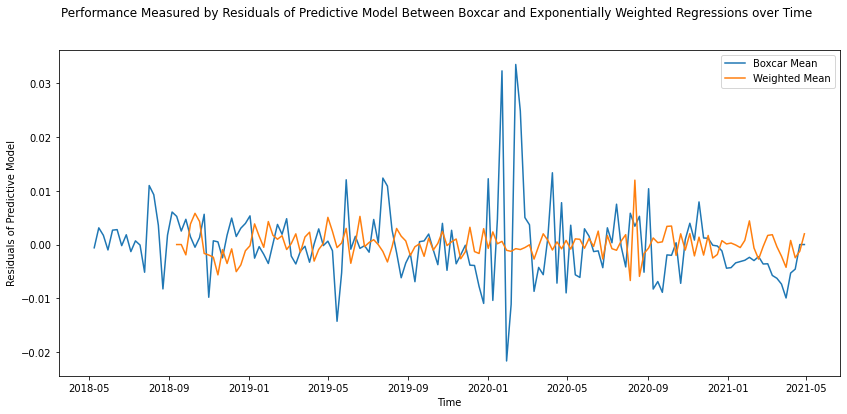

In [231]:
#plot just their averages over time 

fig, ax = plt.subplots(1, figsize=(14,6))
fig.suptitle('Mean Performance Measured by Residuals of Predictive Model Between Boxcar and Exponentially Weighted Regressions over Time');
plt.plot(wednesdays[-len(boxcar_Q_avg):], boxcar_Q_avg, label = 'Boxcar Mean')
plt.plot(wednesdays[-len(weighted_Q_avg):], weighted_Q_avg, label = 'Weighted Mean')

plt.legend()
plt.ylabel('Residuals of Predictive Model')
plt.xlabel('Time');

From the graph above, it is clear to see that on average, we have that the weighted regression is far superior to the boxcar regression when performance is measured by $q_{E,n}$. This makes sense given that the weighted regression should be better at handling moments of higher vol as discussed in class. Boxcar suffers from the initial jump and then the return jump while weighted regressions handle vol events more smoothly. 

The "mean" here just means the mean of all of the different tickers. We take a look at a variety of statistics below. We see that the boxcar mean is lower than the weighted mean which makes sense given its much larger swings negative, and more tellingly, we see that the STD of the Boxcar is nearly 3 times as high as the STD of the Weighted Mean. Of course, $q_{E,n}$ implies that our model is more precise (less error), so having a mean very close to 0 with a tight STD is a good thing.

In [236]:
print('Statistics on Boxcar Mean')
print(pd.DataFrame(boxcar_Q_avg).describe())
print('')
print('Statistics on Weighted Mean')
print(pd.DataFrame(weighted_Q_avg).describe())


Statistics on Boxcar Mean
                0
count  156.000000
mean     0.000036
std      0.006801
min     -0.021652
25%     -0.003613
50%     -0.000208
75%      0.002810
max      0.033488

Statistics on Weighted Mean
                0
count  138.000000
mean     0.000073
std      0.002419
min     -0.006688
25%     -0.001209
50%     -0.000033
75%      0.001393
max      0.011974


We then can take a more in-depth look at the differences in STDs between the two.

In [220]:
#get the STD of the boxcar and weighted Q errors
boxcars_std_lst = []
for unique_n in b_predict['N'].unique():
    days_data = b_predict.loc[(b_predict['N'] == unique_n)]
    std = np.std(days_data['Q'])
    boxcars_std_lst.append(std)
    
weighted_std_lst = []
for unique_n in w_predict['N'].unique():
    days_data = w_predict.loc[(w_predict['N'] == unique_n)]
    std = np.std(days_data['Q'])
    weighted_std_lst.append(std)


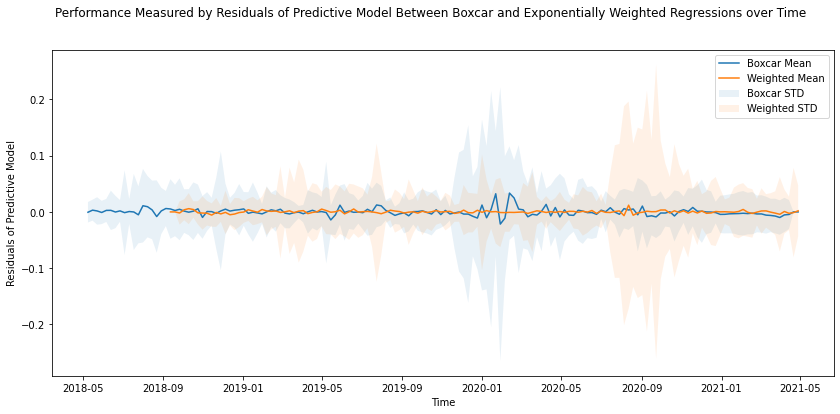

In [230]:
#plot the averages and the STDs this time

fig, ax = plt.subplots(1, figsize=(14,6))
fig.suptitle('Performance Measured by Residuals of Predictive Model Between Boxcar and Exponentially Weighted Regressions over Time');
# fig.tight_layout(pad = 4.0)
plt.plot(wednesdays[-len(boxcar_Q_avg):], boxcar_Q_avg, label = 'Boxcar Mean')
plt.plot(wednesdays[-len(weighted_Q_avg):], weighted_Q_avg, label = 'Weighted Mean')

#generate the STD bands 
top_w = weighted_Q_avg + np.array(weighted_std_lst) 
bottom_w = weighted_Q_avg - np.array(weighted_std_lst)

top_b = boxcar_Q_avg + np.array(boxcars_std_lst) 
bottom_b = boxcar_Q_avg - np.array(boxcars_std_lst)

plt.fill_between(wednesdays[-len(boxcar_Q_avg):], top_b, bottom_b, alpha = 0.1, label = "Boxcar STD")
plt.fill_between(wednesdays[-len(weighted_Q_avg):], top_w, bottom_w, alpha = 0.1, label = "Weighted STD")


plt.legend()
plt.ylabel('Residuals of Predictive Model')
plt.xlabel('Time');

Very interestingly, we find that there are periods where the STD for the weighted is much higher than the STD for Boxcar. This means that the $q_{E,n}$ value for each individual ticker on a given week $n$ are farther apart than they are for the Boxcars - for the period right around 2020-09. Other than that, we see for the most part, the blue band is larger than the orange band which means that the weighted std is lower than the boxcar std. We graph their difference below. When the points are blue, we have that the boxcar's STD is greater than the weighted and red is vice versa. We see an interesting trend that changes over time. Let's explore this further. 

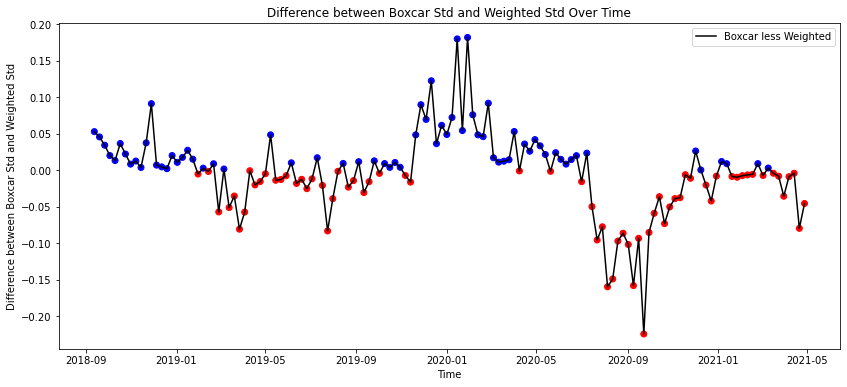

In [273]:
#plot differences between the STDs

w_std = np.array(weighted_std_lst)
b_std = np.array(boxcars_std_lst)[-len(w_std):]
plt.figure(figsize = (14,6))
data =  b_std - w_std

#set up different colors for above and below zero 
scatter = plt.scatter(wednesdays[-len(weighted_Q_avg):], data, c = ['r' if i < 0 else 'b' for i in data])

plt.plot(wednesdays[-len(weighted_Q_avg):], data, c = 'black', label = 'Boxcar less Weighted')

plt.legend()
plt.title('Difference between Boxcar Std and Weighted Std Over Time')
plt.xlabel('Time')
plt.ylabel('Difference between Boxcar Std and Weighted Std');

The findings above might be interesting to explore further later, but given that we would likely be constructing a portfolio of different equities, it is find to use these findings and conclude that for the most part, we would prefer the weighted STD to the boxcar STD. Let's explore 1 more thing, let's look at the $m$ market returns variable we constructed before and see if it is correlated to the difference in the mean errors.

The slope of the linear regression is:  0.14916851218619173
The intercept of the linear regression is:  0.003483828685094432
The R^2 is of the linear regression is:  0.00159432237071655

The values for the curved lined of fit (^2, ^1, const):  6.111 0.086 0.003


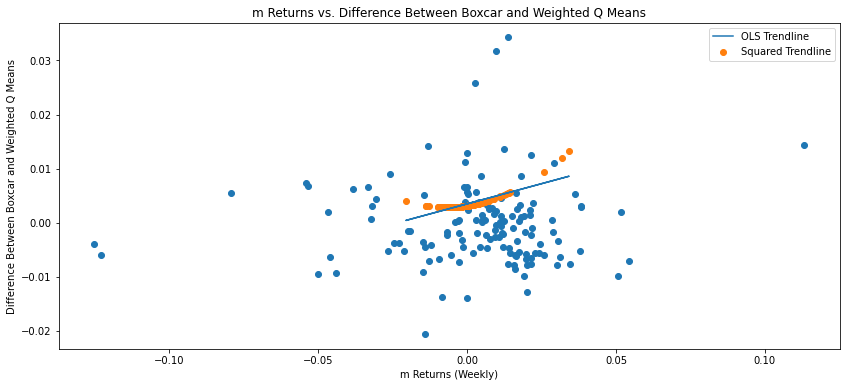

In [313]:
#set up what we want to explore 
#the relationship between how good weighted is and the market returns
#extreme market returns are a proxy for vol 

m_to_use = m['Returns'][-len(w_std):]
b_Q_avg = boxcar_Q_avg[-len(w_std):]
w_Q_avg = weighted_Q_avg
b_w_diff = b_Q_avg - w_Q_avg 

plt.figure(figsize = (14,6))
plt.scatter(m_to_use, b_w_diff)
plt.title('m Returns vs. Difference Between Boxcar and Weighted Q Means')
plt.ylabel('Difference Between Boxcar and Weighted Q Means')
plt.xlabel('m Returns (Weekly)')

#get the OLS line 
df_for_model = pd.DataFrame()
df_for_model['X'] = b_w_diff
df_for_model['Y'] = m_to_use.values
model = statsmodels.formula.api.ols('Y ~ X', data = df_for_model).fit()

fitted_values = b_w_diff * model.params['X'] + model.params['Intercept']

plt.plot(b_w_diff, fitted_values, label = 'OLS Trendline')

#add a curved fit line 
beta_2, beta_1, alpha = np.polyfit(b_w_diff, m_to_use.values, 2)
plt.scatter(b_w_diff, beta_2 * b_w_diff ** 2 + beta_1 * b_w_diff ** 1 + alpha, label = 'Squared Trendline')
plt.legend();

print('The slope of the linear regression is: ', model.params['X'])
print('The intercept of the linear regression is: ', model.params["Intercept"])
print('The R^2 is of the linear regression is: ', model.rsquared)

print('')
print('The values for the curved lined of fit (^2, ^1, const): ', round(beta_2,3), round(beta_1,3), round(alpha,3))

From this graph, we see a couple of outliers when the boxcar is significantly higher than the weighted Q, this makes sense. Further, we see that the regression line is not very good at all, but there is some correlation where the higher the $m$ returns are the bigger the gap between the boxcar and the weighted regression. I suppose that this is an interesting and non-obvious finding. However, it doesn't really make sense that it wouldn't be the same in the opposite direction. Therefore, I have added a curved fit to see if a squared fit would work better.

The curved line also shows us something very interesting. Almost all of the time, we can expect that boxcar has higher $Q$ than weighted, and, as we get further and further away from $ m =0$ we see that these differences become more extreme. It is very interesting to note then that the shape of this effect is NOT symmetric. We would expect that in markets where there are strong moves up and down (high vol) that the boxcar would be much, much worse than the weighted and it seems to me at first glance that if the move is up or down should not affect by how much. However, these results pretty clearly demonstrate that our weighted is even better in moments where there are strong market moves up compared to when there are market moves down. I think that this might be something which could be very interesting to explore further in the future as well as the economic intuition for this is non-obvious for me right now. It might have to do with something psychological in the market when there are moves positive and negative - this would obviously be something difficult to test, but interesting nonetheless.



### Step 4: Conclusion 

From our work above, we see that most of the time, if we were building an entire portfolio, and thus the STD of one particular equity might not be of great concern, we would always pick the weighted because the mean is close to 0 and the STD is 3x lower. If we were only picking one equity, we might be very concerned about the different STD findings above, and take some more time to explore how these effects might be correlated to other things in the markets such as the VIX, week over week returns in the SPY, etc. 

Overall, we find exactly what our intuition tells us we should find. The boxcar strategy, in this case, is inferior to the weighted and especially so in the case of greater market volatility. 